# Код нарезки видео

In [9]:
import cv2
import os

save_folder = 'путь для сохранения'
# Открываем видеофайл
cap = cv2.VideoCapture(" путь к видео")

# Получаем частоту кадров видео
fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0:
    fps = 24  # Если не удалось получить fps, устанавливаем по умолчанию 25

# Вычисляем длительность одного кадра и интервал между сохраняемыми кадрами
frame_duration = 1 / fps
desired_interval = 0.5  # Интервал в секундах (2 кадра в секунду)

next_frame_time = 0
frame_number = 0
saved_frame_number = 1 # Начинаем с 1, чтобы соответствовать маске 'frame_000001.png'

while True:
    ret, frame = cap.read()
    if not ret:
        break
    current_time = frame_number * frame_duration
    if current_time >= next_frame_time:
        # Сохраняем кадр как изображение
        filename = os.path.join(save_folder, f'frame_{saved_frame_number:06d}.png')
        cv2.imwrite(filename, frame)
        saved_frame_number += 12
        next_frame_time += desired_interval
    frame_number += 1

cap.release()

# Код отрисовки разметки в формате yolo8 object detection

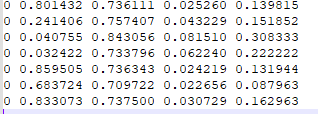

In [22]:
import os
import cv2

# Пути к папкам
images_path = r"C:\Users\vahahat\Downloads\person\aug"
labels_path = r"C:\Users\vahahat\Downloads\person\aug"
output_path = r"C:\Users\vahahat\Downloads\person\check2"


# Создаем папку для сохранения результатов, если она не существует
os.makedirs(output_path, exist_ok=True)

# Функция для чтения разметки из файла
def read_labels(label_file):
    labels = []
    with open(label_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            class_id = int(data[0])
            x_center, y_center, width, height = map(float, data[1:])
            labels.append((class_id, x_center, y_center, width, height))
    return labels


# Функция для рисования прямоугольников на изображении
def draw_bounding_boxes(image, labels):
    height, width, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, w, h = label
        # Переводим нормализованные координаты в абсолютные
        x1 = int((x_center - w / 2) * width)
        y1 = int((y_center - h / 2) * height)
        x2 = int((x_center + w / 2) * width)
        y2 = int((y_center + h / 2) * height)
        
        # Рисуем прямоугольник и метку класса
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

# Основной цикл для обработки изображений и разметки
for filename in os.listdir(images_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(images_path, filename)
        label_path = os.path.join(labels_path, filename.replace(".png", ".txt").replace(".jpg", ".txt"))
        
        # Проверяем наличие файла разметки
        if os.path.exists(label_path):
            # Загружаем изображение
            image = cv2.imread(image_path)
            
            # Загружаем разметку
            labels = read_labels(label_path)
            
            # Наносим разметку на изображение
            image_with_boxes = draw_bounding_boxes(image, labels)
            
            # Сохраняем результат
            output_image_path = os.path.join(output_path, filename)
            cv2.imwrite(output_image_path, image_with_boxes)
            print(f"Обработано и сохранено: {output_image_path}")


Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000001_aug_0.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000001_aug_1.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000001_aug_2.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000013_aug_0.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000013_aug_1.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000013_aug_2.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000025_aug_0.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000025_aug_1.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000025_aug_2.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000037_aug_0.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\check2\frame_000037_aug_1.png
Обработано и сохранено: C:\Users

# Код для аугментации данных

Аугментация изображений для задачи детекции может значительно повысить качество модели, так как увеличивает разнообразие данных и помогает избежать переобучения. Для задачи детекции людей можно использовать различные техники аугментации с сохранением разметки (bounding boxes). Приведу примеры использования различных библиотек: Albumentations, imgaug, и torchvision.transforms.

In [12]:
!pip install opencv-python-headless

In [13]:
!pip install albumentations opencv-python-headless


## 1. Аугментация с использованием Albumentations
**Albumentations** — это мощная и быстрая библиотека для аугментации изображений и аннотаций, включая bounding boxes.

In [21]:
import os
import cv2
import albumentations as A

# Пути к папкам
images_path = r"C:\Users\vahahat\Downloads\person\images\train"
labels_path = r"C:\Users\vahahat\Downloads\person\labels\train"
output_path = r"C:\Users\vahahat\Downloads\person\aug"

# Параметр: во сколько раз увеличить выборку
augmentation_factor = 3  # Укажите нужное количество

# Создаем папку для сохранения результатов, если она не существует
os.makedirs(output_path, exist_ok=True)

# Определяем список аугментаций
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(
        shift_limit=0.1, 
        scale_limit=0.2, 
        rotate_limit=15, 
        border_mode=0, 
        p=0.5
    ),
    A.GaussNoise(p=0.2)
], bbox_params=A.BboxParams(
    format='yolo',
    label_fields=['class_labels'],
    min_area=0.0,
    min_visibility=0.0,
    check_each_transform=False  # Отключаем проверку после каждого преобразования
))

# Функция для чтения разметки из файла
def read_labels(label_file):
    labels = []
    with open(label_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            class_id = int(data[0])
            x_center, y_center, width, height = map(float, data[1:])
            labels.append((class_id, x_center, y_center, width, height))
    return labels

# Функция для сохранения разметки в файл
def save_labels(label_file, bboxes):
    with open(label_file, 'w') as f:
        for class_id, bbox in bboxes:
            x_center, y_center, w, h = bbox
            f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

# Функция для коррекции bounding boxes
def clip_bbox(bbox):
    """
    Обрезка координат bounding box до диапазона [0.0, 1.0].
    Если после обрезки ширина или высота становятся <= 0, возвращаем None.
    """
    x_center, y_center, w, h = bbox

    # Вычисляем x_min, y_min, x_max, y_max
    x_min = x_center - w / 2
    y_min = y_center - h / 2
    x_max = x_center + w / 2
    y_max = y_center + h / 2

    # Обрезаем до диапазона [0.0, 1.0]
    x_min = max(0.0, x_min)
    y_min = max(0.0, y_min)
    x_max = min(1.0, x_max)
    y_max = min(1.0, y_max)

    # Пересчитываем ширину и высоту
    w = x_max - x_min
    h = y_max - y_min

    # Проверяем, что ширина и высота больше 0
    if w <= 0 or h <= 0:
        return None

    # Пересчитываем центр
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    return x_center, y_center, w, h

# Функция для аугментации изображения и разметки
def augment_image(image, bboxes):
    # Подготовка bounding boxes для Albumentations
    bbox_list = []
    class_labels = []
    for b in bboxes:
        class_id, x_center, y_center, w, h = b
        clipped_bbox = clip_bbox((x_center, y_center, w, h))
        if clipped_bbox is not None:
            bbox_list.append(clipped_bbox)
            class_labels.append(class_id)
    if not bbox_list:
        # Если нет валидных bounding boxes, возвращаем исходное изображение
        return image, []

    augmented = transform(image=image, bboxes=bbox_list, class_labels=class_labels)

    # Корректируем bounding boxes после аугментации
    corrected_bboxes = []
    for class_id, bbox in zip(augmented['class_labels'], augmented['bboxes']):
        clipped_bbox = clip_bbox(bbox)
        if clipped_bbox is not None:
            corrected_bboxes.append((class_id, clipped_bbox))

    return augmented['image'], corrected_bboxes

# Основной цикл для обработки всех изображений и файлов разметки
for filename in os.listdir(images_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(images_path, filename)
        label_path = os.path.join(labels_path, filename.rsplit('.', 1)[0] + ".txt")

        # Проверяем наличие файла разметки
        if os.path.exists(label_path):
            # Загружаем изображение
            image = cv2.imread(image_path)
            height, width, _ = image.shape

            # Загружаем разметку
            bboxes = read_labels(label_path)

            # Аугментация несколько раз для увеличения выборки
            for i in range(augmentation_factor):
                # Аугментация изображения и разметки
                aug_image, aug_bboxes = augment_image(image, bboxes)

                if not aug_bboxes:
                    # Если после аугментации нет валидных bounding boxes, пропускаем
                    continue

                # Сохранение аугментированного изображения с уникальным именем
                output_image_path = os.path.join(output_path, f"{filename.rsplit('.', 1)[0]}_aug_{i}.png")
                cv2.imwrite(output_image_path, aug_image)

                # Сохранение аугментированной разметки
                output_label_path = os.path.join(output_path, f"{filename.rsplit('.', 1)[0]}_aug_{i}.txt")
                save_labels(output_label_path, aug_bboxes)

                print(f"Обработано и сохранено: {output_image_path}")

Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000001_aug_0.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000001_aug_1.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000001_aug_2.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000013_aug_0.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000013_aug_1.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000013_aug_2.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000025_aug_0.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000025_aug_1.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000025_aug_2.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000037_aug_0.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\frame_000037_aug_1.png
Обработано и сохранено: C:\Users\vahahat\Downloads\person\aug\fra